In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

Load Stephanie's Praesepe catalogue

In [4]:
douglas = pd.read_csv("../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


In [15]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

(1.5, 0.1)

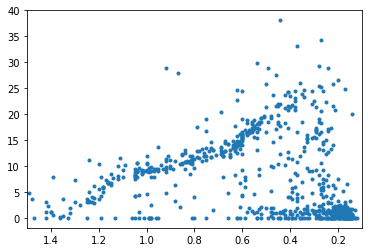

In [17]:
plt.plot(douglas.Mass, douglas.period, ".")
plt.xlim(1.5, 0.1)

Load the Gaia crossmatch for the clusters

In [24]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Praesepe"
pg = gaia.iloc[m]
pg.head()
pg["source_id"] = pg.Source
print(np.shape(pg))
pg.head()

(938, 10)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Source,Cluster,RA_ICRS,DE_ICRS,Gmag,plx,e_plx,_RA.icrs,_DE.icrs,source_id
1994,685747814353991296,Praesepe,133.15933,21.15502,15.859,5.639,0.034,133.15933,21.15502,685747814353991296
1995,665141141087298688,Praesepe,130.22501,21.75663,18.489,5.629,0.020,130.22501,21.75663,665141141087298688
1996,665203233431193344,Praesepe,129.73385,21.94080,18.440,5.334,0.055,129.73385,21.94080,665203233431193344
1997,664963024499946496,Praesepe,130.84387,21.67163,10.404,5.556,0.040,130.84387,21.67163,664963024499946496
1998,664976218639479296,Praesepe,130.76188,21.75375,17.337,6.153,0.093,130.76188,21.75375,664976218639479296


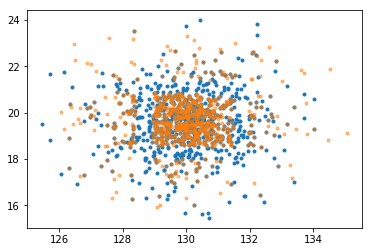

In [26]:
plt.plot(pg.RA_ICRS, pg.DE_ICRS, ".")
plt.plot(douglas._RA, douglas._DE, ".", alpha=.5)

In [73]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    id1, id2 = np.ones((len(ra1)))*np.nan, np.ones((len(ra2)))*np.nan
    ind1, ind2 = [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:  # If there is a star (a) within 5 arcsecs of this target star (i)
                m = np.arange(len(ra2))[m[0]]  # create an index mask, selecting the position of star a
            if not np.arange(len(ra2))[m] in np.array(ind2):  # If this star has not already been identified
                ind1.append(i)  # add i to the list of inds1
                ind2.append(np.arange(len(ra2))[m])  # Add a to the list of inds2
                id1[i] = i
                id2[m] = i
    
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return m1, m2, id1, id2

100%|██████████| 938/938 [00:01<00:00, 673.93it/s]


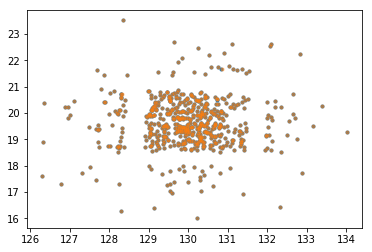

In [74]:
inds1, inds2, id1, id2 = find_min_dist(pg.RA_ICRS, pg.DE_ICRS, douglas._RA, douglas._DE)
plt.plot(pg.RA_ICRS.values[inds1], pg.DE_ICRS.values[inds1], ".")
plt.plot(douglas._RA.values[inds2], douglas._DE.values[inds2], ".", alpha=.5)

In [75]:
pg["id"] = id1
douglas["id"] = id2

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


4.0 4.0


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


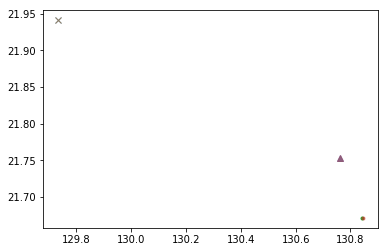

In [76]:
print(min(pg.id.values[pg.id.values > 3]), min(douglas.id.values[douglas.id.values > 3]))
m1 = pg.id.values == 2
m2 = douglas.id.values == 2
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], "x")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], "x", alpha=.5)

m1 = pg.id.values == 3
m2 = douglas.id.values == 3
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], ".")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], ".", alpha=.5)

m1 = pg.id.values == 4
m2 = douglas.id.values == 4
plt.plot(pg.RA_ICRS.values[m1], pg.DE_ICRS.values[m1], "^")
plt.plot(douglas._RA.values[m2], douglas._DE.values[m2], "^", alpha=.5)

In [78]:
m1 = np.isfinite(pg.id.values)
m2 = np.isfinite(douglas.id.values)
df = pd.merge(pg.iloc[m1], douglas.iloc[m2], on="id", how="right")
print(np.shape(pg.iloc[m1]), np.shape(douglas.iloc[m2]), np.shape(df))

(549, 12) (549, 31) (549, 42)


In [79]:
source_ids_praesepe = pd.DataFrame(dict({"source_id": df.source_id}))
source_ids_praesepe.to_csv("../data/source_ids_praesepe.csv")

Log in here: https://gea.esac.esa.int/archive/

After performing the following query with the above data file uploaded:

SELECT *

FROM user_table_name

JOIN gaiadr2.gaia_source AS gaia USING (source_id)

Load gaia table.

In [240]:
gaia = pd.read_csv("../data/praesepe-result.csv")

In [241]:
df2 = pd.merge(gaia, df, on="source_id")
# for i in df2.keys():
#     print(i)

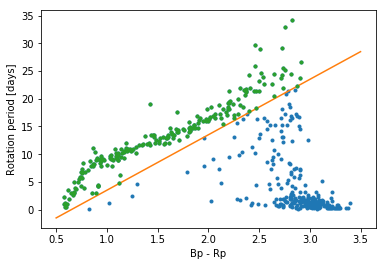

In [242]:
m = df2.period.values > 0.
m &= np.isfinite(df2.phot_bp_mean_mag.values - df2.phot_rp_mean_mag.values)
m &= np.isfinite(df2.period.values)
x = df2.phot_bp_mean_mag.values[m] - df2.phot_rp_mean_mag.values[m]
y = df2.period.values[m]

plt.plot(x, y, ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(.5, 3.5, 100)
plt.plot(xs, 10*xs - 6.5)

m = 10*x - 6.5 < y 
plt.plot(x[m], y[m], ".")

In [243]:
A = np.vander(x[m], 6)
ATA = np.dot(A.T, A)
p = np.linalg.solve(ATA, np.dot(A.T, y[m]))

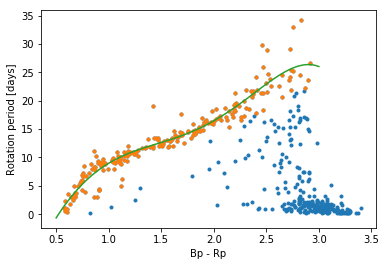

In [244]:
plt.plot(x, y, ".")
plt.plot(x[m], y[m], ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(.5, 3, 100)
plt.plot(xs, np.polyval(p, xs))

Now in log space.

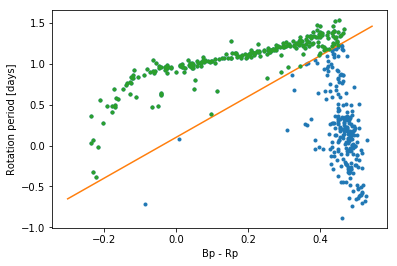

In [292]:
plt.plot(np.log10(x), np.log10(y), ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

xs = np.linspace(np.log10(.5), np.log10(3.5), 100)
plt.plot(xs, 2.5*xs + .1)

m = 2.5*np.log10(x) + .1 < np.log10(y) 
plt.plot(np.log10(x[m]), np.log10(y[m]), ".")

x1, y1 = np.log10(x[m]), np.log10(y[m])
x2, y2 = np.log10(x[~m]), np.log10(y[~m])

In [293]:
A = np.vander(x1, 6)
ATA = np.dot(A.T, A)
p = np.linalg.solve(ATA, np.dot(A.T, y1))

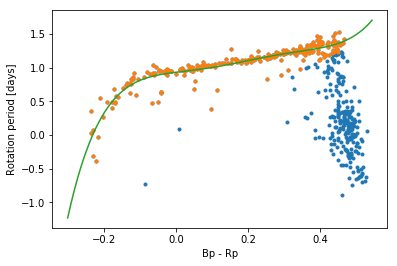

In [294]:
plt.plot(np.log10(x), np.log10(y), ".")
plt.plot(x1, y1, ".")
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")

plt.plot(xs, np.polyval(p, xs))

What is the scatter about the line?

0.012477919076642991


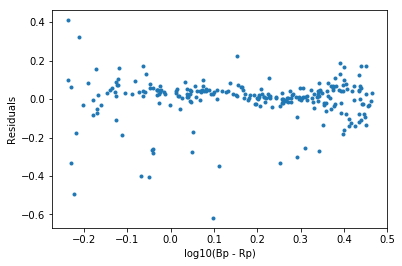

In [295]:
resids = y1 - np.polyval(p, x1)
plt.plot(x1, resids, ".")
plt.xlabel("log10(Bp - Rp)")
plt.ylabel("Residuals")
var = np.var(resids)
std = np.sqrt(var)
print(var)

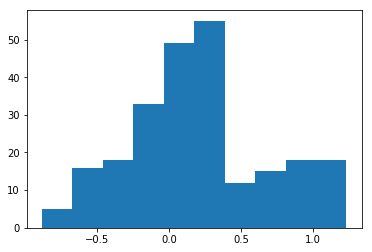

In [296]:
plt.hist(y2);

Generate data that look similar to this.

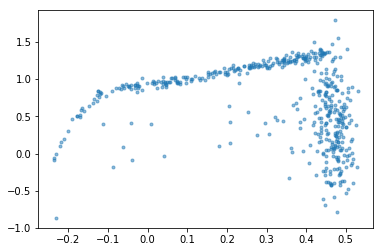

In [325]:
# Select some stars to be outliers
f = .1  # outlier fraction
random = np.random.uniform(0, 1, len(x1))
m = random > f  # m masks out the outliers. 

# Rotation main sequence                              # noise standard deviation
y1_model = np.polyval(p, x1) + np.random.randn(len(x1)) * (std/3)#  + .1*x1)
plt.plot(x1[m], y1_model[m], ".", alpha=.5)

# Outliers
y3 = np.polyval(p, x1[~m]) - np.random.uniform(0, 1, len(x1[~m]))
plt.plot(x1[~m], y3, ".", color="tab:blue", alpha=.5)

# M dwarfs
y2_model = np.random.randn(len(x2))*.5 + .4
plt.plot(x2, y2_model, ".", color="tab:blue", alpha=.5)

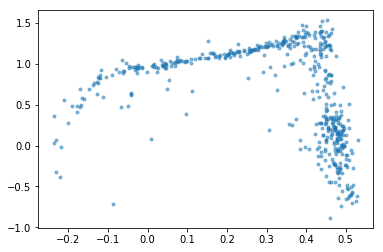

In [324]:
plt.plot(np.log10(x), np.log10(y), ".", alpha=.5)

Just look at the M dwarfs

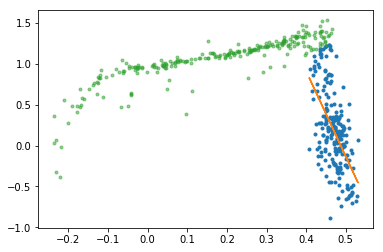

In [343]:
m = x2 > .4
plt.plot(x2[m], y2[m], ".")

A = np.vander(x2[m], 2)
ATA = np.dot(A.T, A)
p = np.linalg.solve(ATA, np.dot(A.T, y2[m]))
plt.plot(x2[m], np.polyval(p, x2[m]))

plt.plot(x1, y1, ".", alpha=.5)

array([-1.79446347,  1.02863315])

Load the Hyades

In [172]:
hyades = pd.read_csv("../data/hyades_compilation.csv")

Text(0,0.5,'Rotation period [days]')

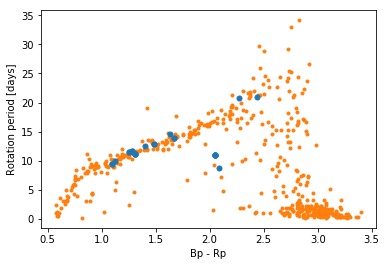

In [178]:
m = hyades.prot > 0.
m &= hyades.radial_velocity > 30.
plt.plot(hyades.bp[m] - hyades.rp[m], hyades.prot[m], ".", ms=10, zorder=1)

plt.plot(x, y, ".", zorder=0)
plt.xlabel("Bp - Rp")
plt.ylabel("Rotation period [days]")